<a href="https://colab.research.google.com/github/TehLedRed/SpringerManuscript/blob/main/Simulation/NegativeBinomial/results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
!pip install import-ipynb
import import_ipynb
mpl.rcParams['figure.dpi']=100

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial
import nbCure

/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial
importing Jupyter notebook from nbCure.ipynb


# Functions

## Mean differences

In [ ]:
def sumSq(y, yhat):
  ss = np.sum((yhat - y)**2)
  return ss

def sumAbs(y, yhat):
  abs_dif = np.absolute(yhat - y)
  return np.sum(abs_dif)

def Spop(phi, theta, F):
    y = (1/(1 + phi*theta*F))**(1/phi)
    y = np.where(y < 0, 1e-10, y)
    y = np.where(y > 1, 1.0, y)
    return y

def SpopPCM(theta, F):
    y = np.exp(-theta*F)
    y = np.where(y < 0, 1e-10, y)
    y = np.where(y > 1, 1.0, y)
    return y

def simResults(path_sim, path_data, n = 250, phi = 0.1, loop = 100, model = 1):

  d_eta = []
  d_m = []
  d_S1 = []
  d_Sp = []
  d_p = []
  for i in range(1, loop +1):
    sim = pd.read_csv(path_sim + str(i) +  "_TestRes.csv")
    data = pd.read_csv(path_data + str(i) +  "_TestData.csv")

    ss_eta = sumSq(y = np.log(data.theta), yhat = sim.eta)
    d_eta.append(ss_eta)

    ss_m = sumAbs(y = data.m, yhat = sim.mi)
    d_m.append(ss_m)

    S1 = np.exp(-data.t)
    ss_S1 = sumSq(y = S1, yhat = sim.S1)
    d_S1.append(ss_S1)

    theta_hat = np.exp(sim.eta)

    if (model == 1):
      Sp = Spop(phi, data.theta, F = 1 - S1)
      Sp_hat = Spop(phi, theta = theta_hat, F = 1 - sim.S1)
      p_hat = (1 + phi*theta_hat)**(- (1/phi))
      p0 = (1 + phi*data.theta)**(- (1/phi))
    else:
      Sp = SpopPCM(theta = data.theta, F = 1 - S1)
      Sp_hat = SpopPCM(theta = theta_hat, F = 1 - sim.S1)
      p_hat = np.exp(-theta_hat)
      p0 = np.exp(-data.theta)

    ss_Sp = sumSq(y = Sp, yhat = Sp_hat)
    d_Sp.append(ss_Sp)

    ss_p = sumSq(y = p0, yhat = p_hat)
    d_p.append(ss_p)

  tab = pd.DataFrame(zip(d_Sp, d_eta, d_S1, d_m, d_p),
            columns = ["Sp", "eta", "S1", "M", "p0"])

  mean = pd.DataFrame(tab.sum()/(loop*n), columns=['mean']).T

  mean.insert(0, "n", n, True)
  return mean

## AUC

In [ ]:
def aucFI(eta, phi):
  theta = np.exp(eta)

  if (phi==None):
    pc = np.exp(-theta)
  else:
    term = 1 + phi*theta
    pc = np.power(term, -(1/phi))

  seq = np.arange(0,1,0.01)
  TPR = []
  FPR = []

  for i in seq:
    TPR.append(np.sum(np.where(pc <= i, 1, 0) * (1-pc))/ np.sum(1-pc))
    FPR.append(np.sum(np.where(pc <= i, 1, 0) * pc)/ np.sum(pc))

  TPR = np.array(TPR)
  FPR = np.array(FPR)

  return np.sum((TPR[:-1] + TPR[1:])*(FPR[1:] - FPR[:-1])*0.5)



## Plot $S_1(t)$ curves

In [ ]:
def q1(x):
  return x.quantile(0.025)

def q2(x):
  return x.quantile(0.5)

def q3(x):
  return x.quantile(0.975)

In [ ]:
def calc_mat_plot(train_data, t_seq):
    '''
    Returns two matrices to be used later in alpha estimation, each matrix's
    shape equals to (#of indivuals x 5) as g = 5.
    '''
    train_t = train_data['t'].values[np.where(train_data['delta'].values == 1)]
    g = np.quantile(train_t, [0, 0.2, 0.4, 0.6, 0.8, 1])
    g[-1] = t_seq.max()

    t1 = t_seq.reshape(-1,1) - g[:-1]
    t2 = g[1:] - g[:-1]

    indicator2 = t_seq.reshape(-1,1) > g[1:]
    cat = np.sum(indicator2, axis = 1)
    indicator1 = keras.utils.to_categorical(cat, 5)

    denom = np.add(indicator1*t1, indicator2*t2)

    return denom


def calc_S1(alpha, matDenom):
  '''
  Returns estimated S1 vector with shape (# of individuals x 1)
  '''
  x = np.exp(-(matDenom @ alpha))
  return np.clip(x, np.finfo(float).eps, 1.0)



In [ ]:
def plotS1curves(alpha_hat, phi, n):

  seq_t = np.linspace(0, 7, 600)
  S1 = pd.DataFrame(columns = seq_t)
  for sample in range(0,100):
      train_data = pd.read_csv(path + str(sample + 1) + "_TestData" + '.csv')
      matDenom = calc_mat_plot(train_data, seq_t)
      temp = calc_S1(alpha_hat.iloc[sample].to_numpy().reshape(5,1), matDenom).reshape(-1)
      temp = pd.DataFrame([temp], columns = seq_t)
      S1 = pd.concat([S1, temp], ignore_index=True)
  S1curves = S1.agg([q1, q2, q3])

  fig, ax = plt.subplots()
  fig.set_size_inches(10, 5)
  ax.set(ylim=(-.01, 1.02))
  ax.plot(seq_t, calc_S1(np.ones([5,1]), matDenom), color="r", linestyle="-")
  ax.plot(seq_t, S1curves.iloc[1].values, color="b", linestyle="-")
  ax.plot(seq_t, S1curves.iloc[0].values, color="b", linestyle="--")
  ax.plot(seq_t, S1curves.iloc[2].values, color="b", linestyle="--")
  ax.grid(True)
  if (phi==None):
    plt.title('n = ' + str(n), fontsize = 40)
  else:
    plt.title('Φ = '+ str(phi) +', n = ' + str(n), fontsize = 40)
  plt.show()


In [ ]:
def plotS1curves2(alpha_hat, train_data, phi, n):

  seqT = np.linspace(0, 7, 600)
  resStat = alpha_hat.agg(['mean', 'std', q1, q2, q3])

  matSeq = calc_mat_plot(train_data, seqT)

  fig, ax = plt.subplots()
  fig.set_size_inches(10, 5)
  ax.set(ylim=(-.01, 1.02))
  ax.plot(seqT, calc_S1(np.ones([5,1]), matSeq), color="r", linestyle="-")
  ax.plot(seqT, calc_S1(resStat.loc["q2"].to_numpy().reshape(5,1), matSeq), color="b", linestyle="-")
  ax.plot(seqT, calc_S1(resStat.loc["q1"].to_numpy().reshape(5,1), matSeq), color="b", linestyle="--")
  ax.plot(seqT, calc_S1(resStat.loc["q3"].to_numpy().reshape(5,1), matSeq), color="b", linestyle="--")
  ax.grid(True)
  plt.title('phi = '+ str(phi) +', n = ' + str(n))
  plt.show()

# $M \sim \text{Poisson}$

## Empirical pointwise 95% confidence intervals for $S_1(t)$

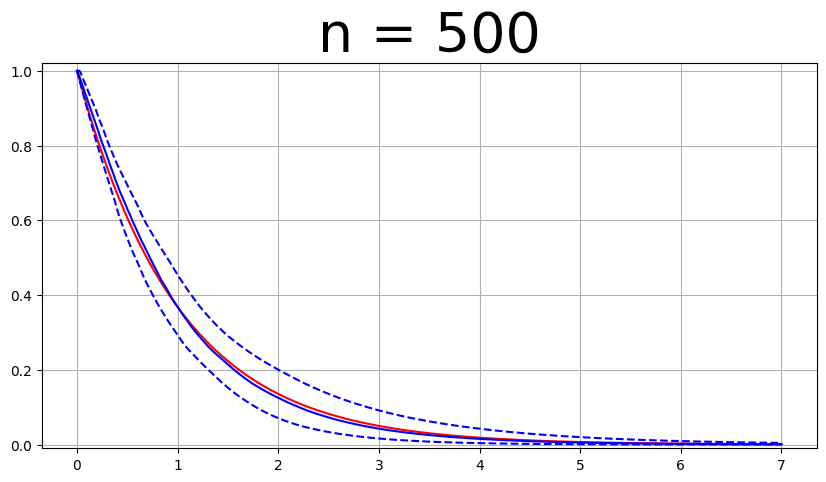

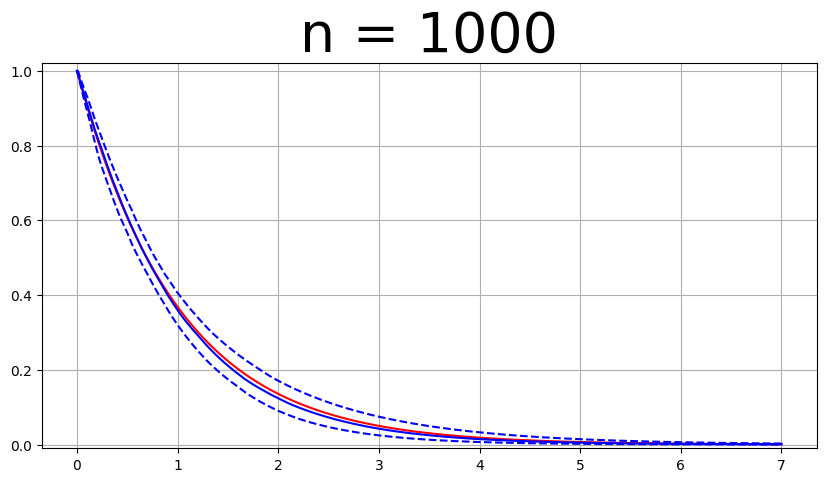

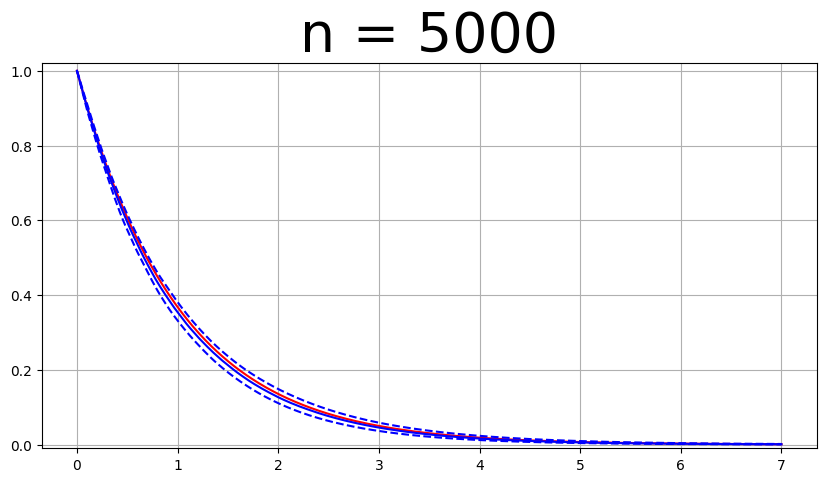

In [ ]:
# Poisson model
for j in [500, 1000, 5000]:
  path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/n" + str(j) + "/"
  alpha_hat = pd.read_csv("/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/n" + str(j) + "/params_n" +  str(j) + ".csv")
  plotS1curves(alpha_hat, phi=None, n=j)

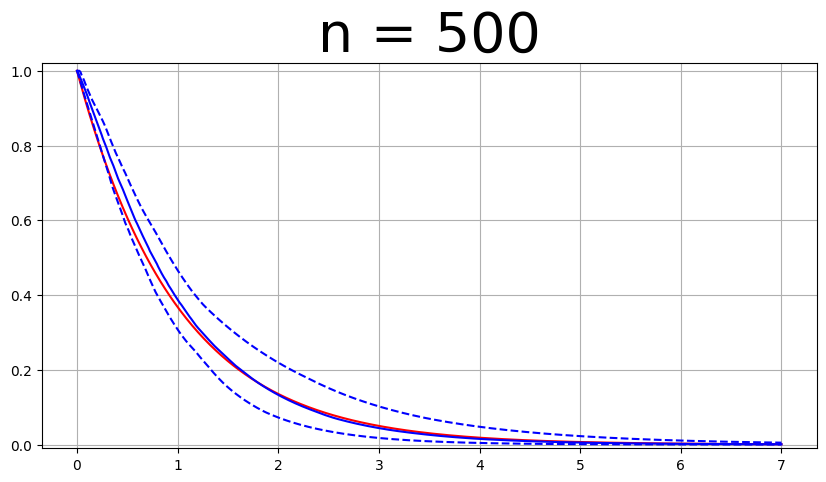

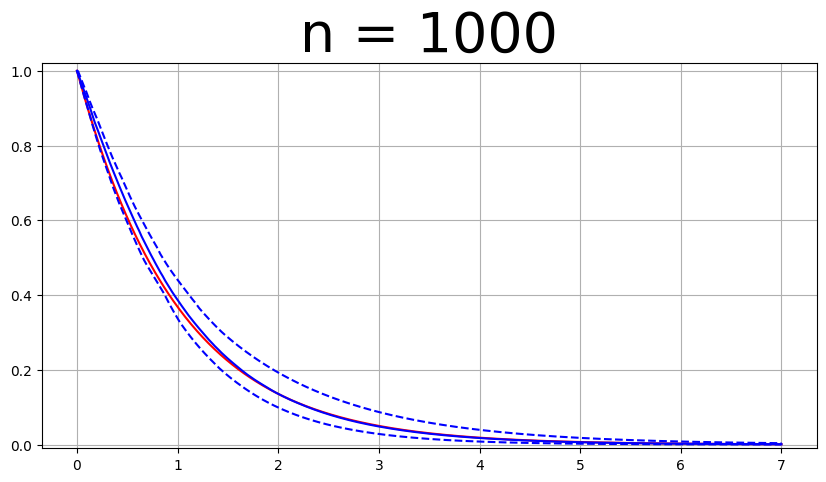

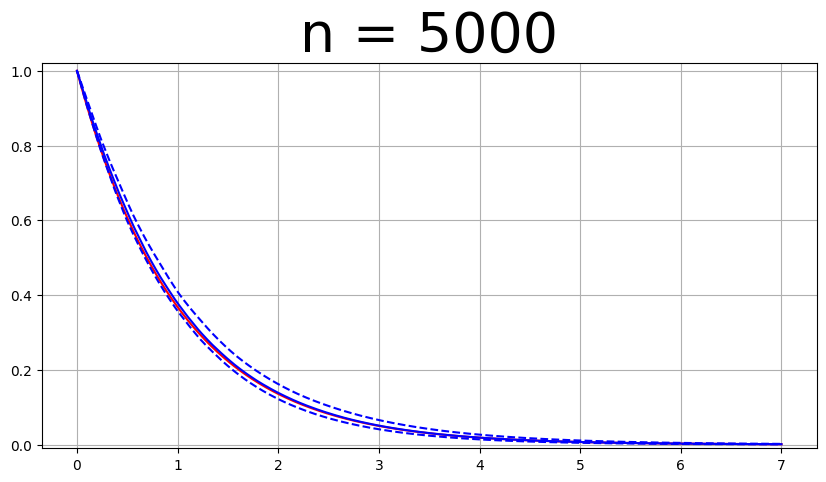

In [ ]:
# NB model
for j in [500, 1000, 5000]:
  path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/n" + str(j) + "/"
  alpha_hat = pd.read_csv("poisson_n" + str(j) + "/params_n" +  str(j) + ".csv")
  plotS1curves(alpha_hat, phi=None, n=j)

## Mean difference

In [ ]:
# Poisson model
sim = pd.DataFrame(columns = ["n", "Sp", "eta", "S1", "M", "p0"])
for j in [500, 1000, 5000]:
  path_data = path_sim = "/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/n" + str(j) + "/"
  temp = simResults(path_sim, path_data, n = j*0.25, phi = None, model = 2)
  sim = pd.concat([sim, temp], ignore_index=True)
sim

,n,Sp,eta,S1,M,p0
0,125.0,0.031885,0.811638,0.001125,0.713748,0.042243
1,250.0,0.023671,0.592476,0.000319,0.629459,0.031686
2,1250.0,0.017309,0.436762,0.000123,0.567622,0.023141


In [ ]:
# NB
sim = pd.DataFrame(columns = ["n", "Sp", "eta", "S1", "M", "p0"])
for j in [500, 1000, 5000]:
  path_data = "/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/n" + str(j) + "/"
  path_sim = "poisson_n" + str(j) + "/"
  temp = simResults(path_sim, path_data, n = j*0.25, phi = 0.01, model = 1)
  sim = pd.concat([sim, temp], ignore_index=True)
sim

,n,Sp,eta,S1,M,p0
0,125.0,0.034323,0.923800,0.001741,0.797420,0.043460
1,250.0,0.026620,0.676092,0.000755,0.706891,0.033795
2,1250.0,0.018399,0.461016,0.000172,0.600151,0.023513


## AUC

In [ ]:
# Poisson model
auc = pd.DataFrame(columns = ["n", "Train AUC", "Test AUC"])
for j in [500, 1000, 5000]:
  path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/n" + str(j) + "/"
  train_auc = []
  test_auc = []
  for sample in range(1,101):
    train_res = pd.read_csv(path + str(sample) + "_TrainRes" + '.csv')
    test_res = pd.read_csv(path + str(sample) + "_TestRes" + '.csv')
    train_auc.append(aucFI(train_res.eta.values, None))
    test_auc.append(aucFI(test_res.eta.values, None))

  temp = pd.DataFrame({'n': j, 'Train AUC': train_auc, 'Test AUC': test_auc})
  auc = pd.concat([auc, temp])

auc.groupby(['n']).agg('mean')

,Train AUC,Test AUC
n,,
500,0.862100,0.844204
1000,0.848263,0.839596
5000,0.833405,0.830950


In [ ]:
# NB model
auc = pd.DataFrame(columns = ["n", "Train AUC", "Test AUC"])
for j in [500, 1000, 5000]:
  path = "poisson_n" + str(j) + "/"
  train_auc = []
  test_auc = []
  for sample in range(1,101):
    train_res = pd.read_csv(path + str(sample) + "_TrainRes" + '.csv')
    test_res = pd.read_csv(path + str(sample) + "_TestRes" + '.csv')
    train_auc.append(aucFI(train_res.eta.values, 0.01))
    test_auc.append(aucFI(test_res.eta.values, 0.01))

  temp = pd.DataFrame({'n': j, 'Train AUC': train_auc, 'Test AUC': test_auc})
  auc = pd.concat([auc, temp])

auc.groupby(['n']).agg('mean')

,Train AUC,Test AUC
n,,
500,0.868450,0.852270
1000,0.868474,0.859518
5000,0.855207,0.852680


# $M \sim \text{Negative Binomial}$



## Empirical pointwise 95% confidence intervals for $S_1(t)$

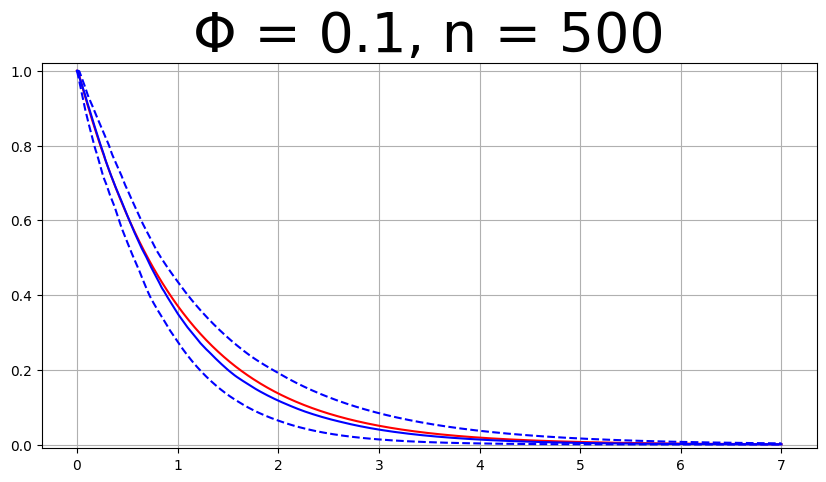

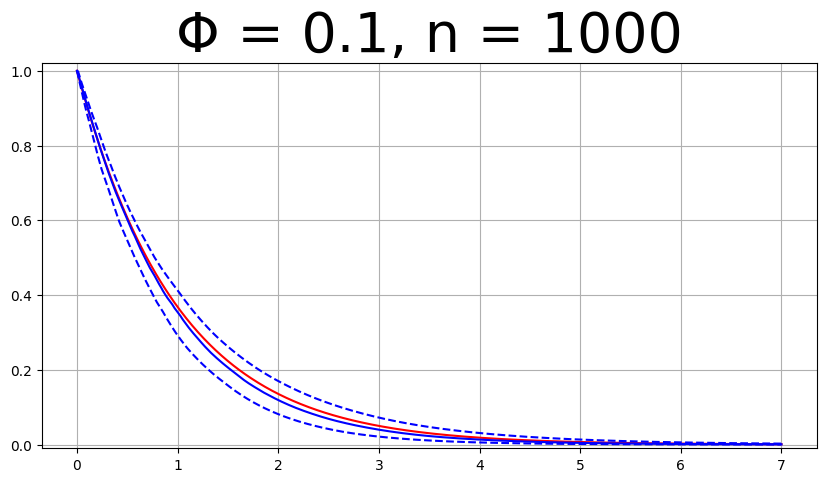

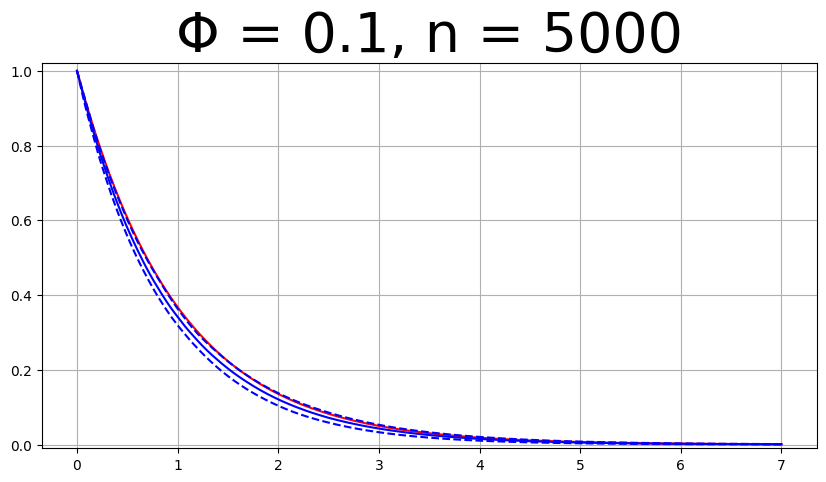

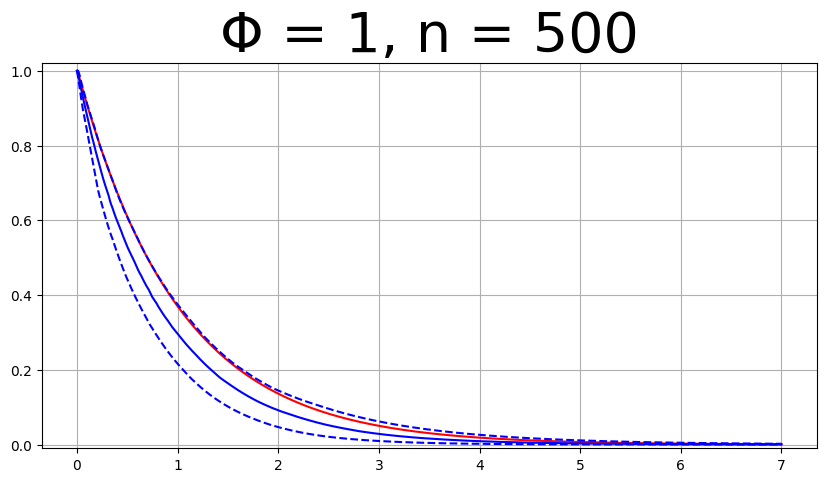

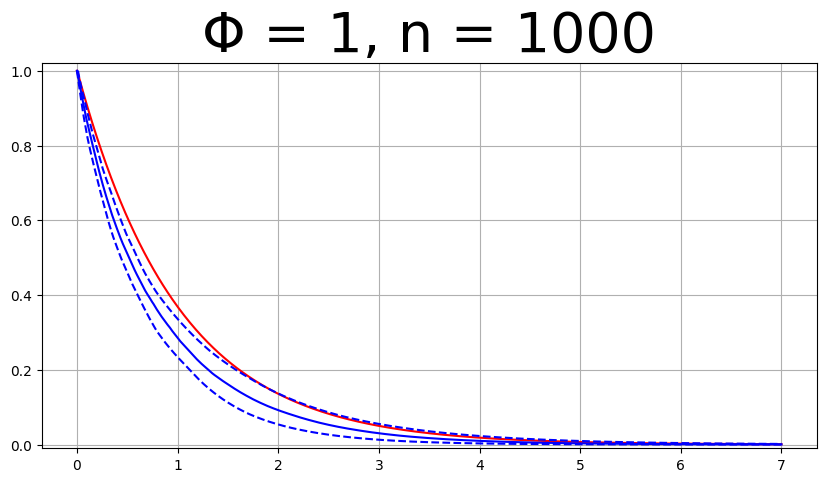

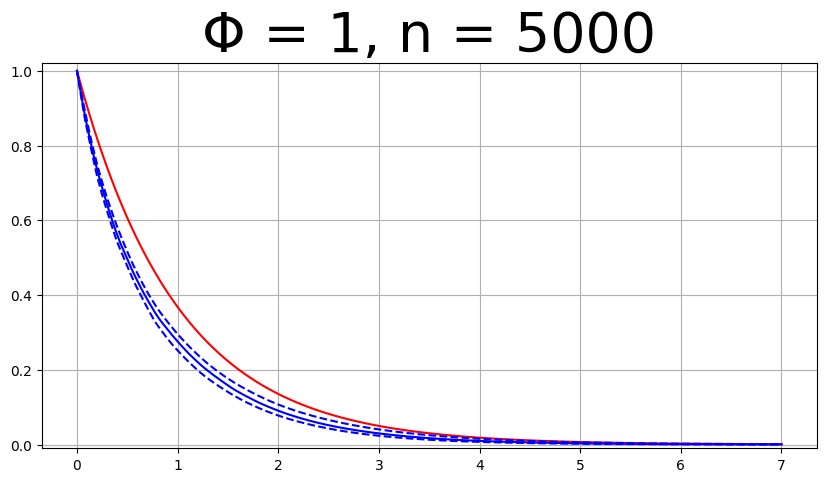

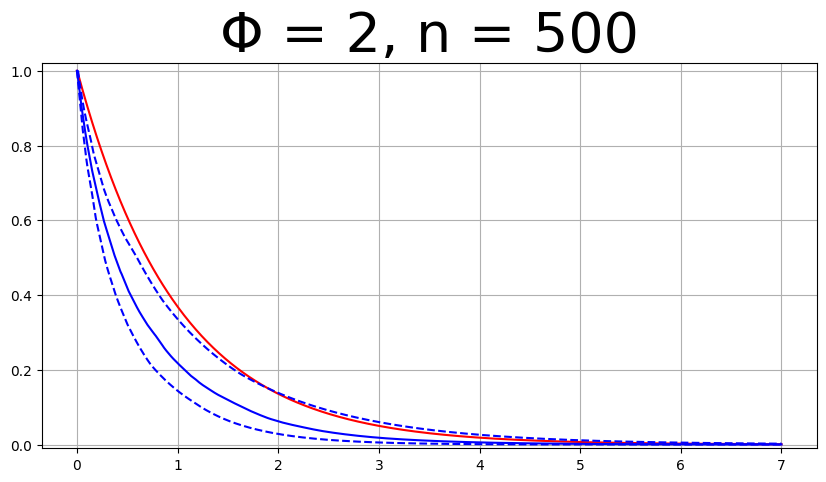

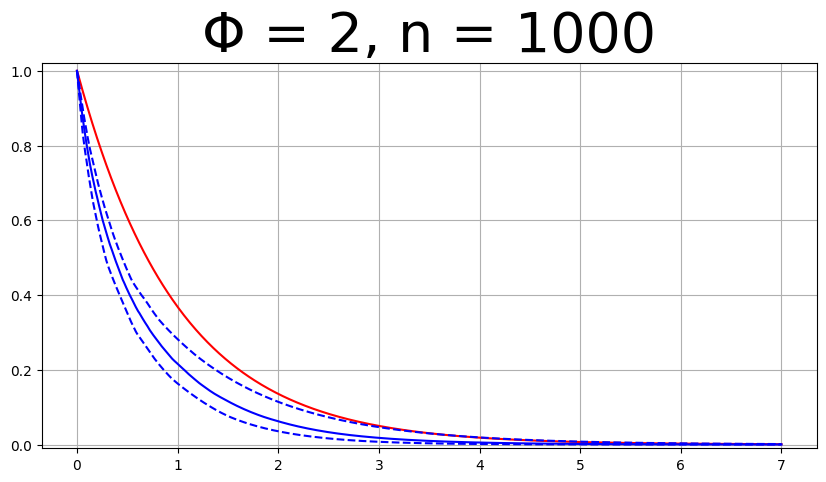

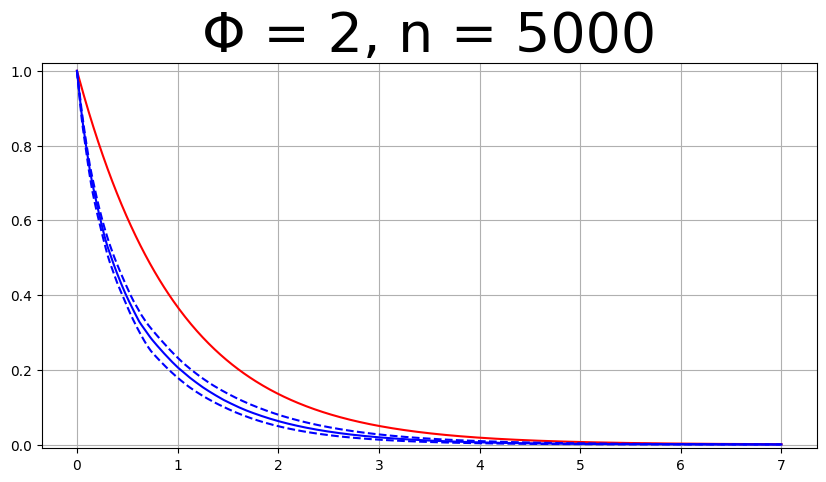

In [ ]:
# Poisson model
for i in [0.1, 1, 2]:
  for j in [500, 1000, 5000]:
    path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial/phi" + str(i) + "/n" + str(j) + "/"
    alpha_hat = pd.read_csv("/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/phi" + str(i) + "/n" + str(j) + "/params_n" +  str(j) + ".csv")
    plotS1curves(alpha_hat, i, j)

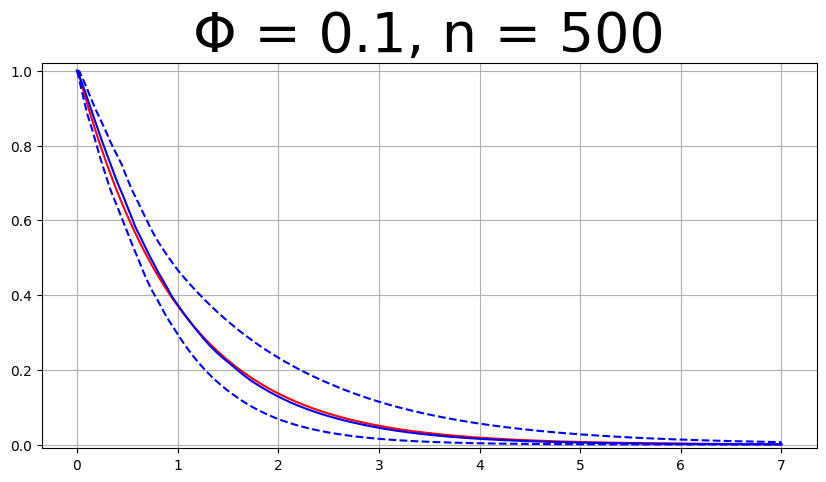

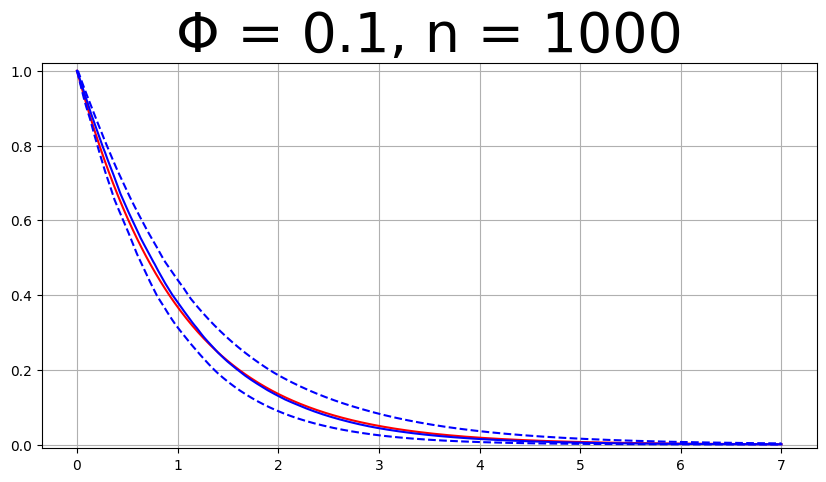

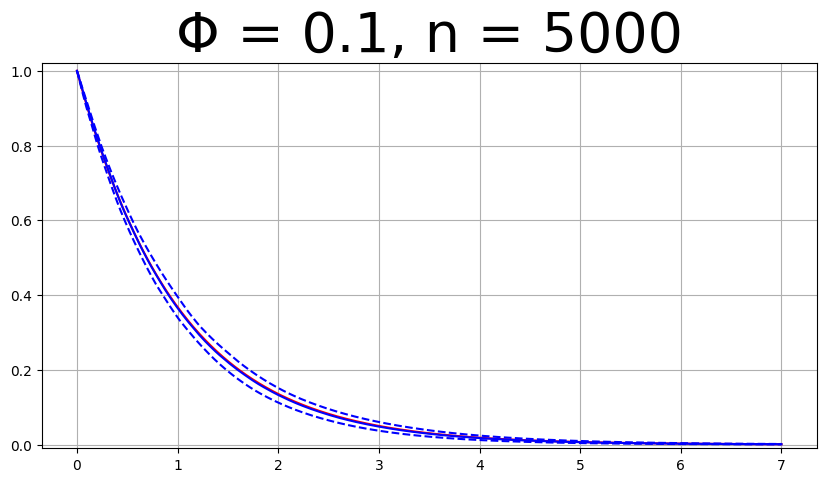

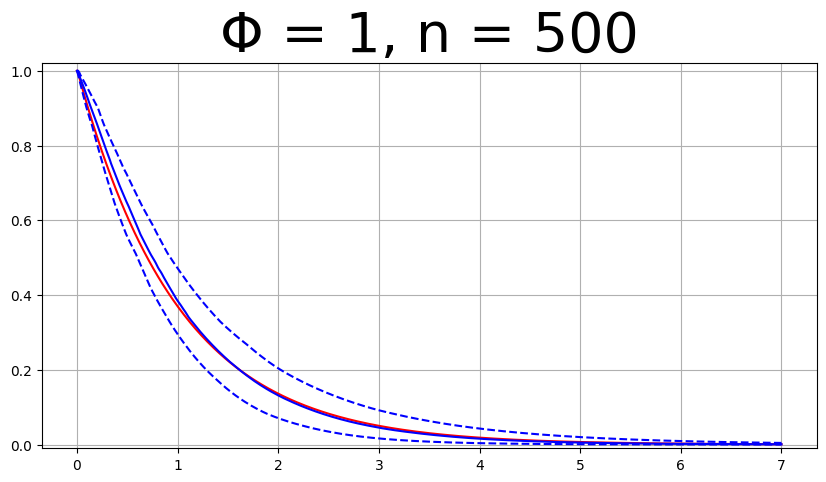

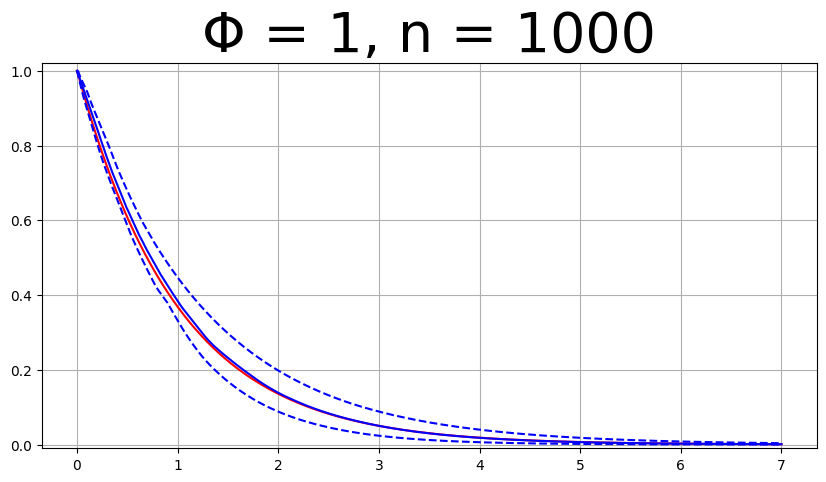

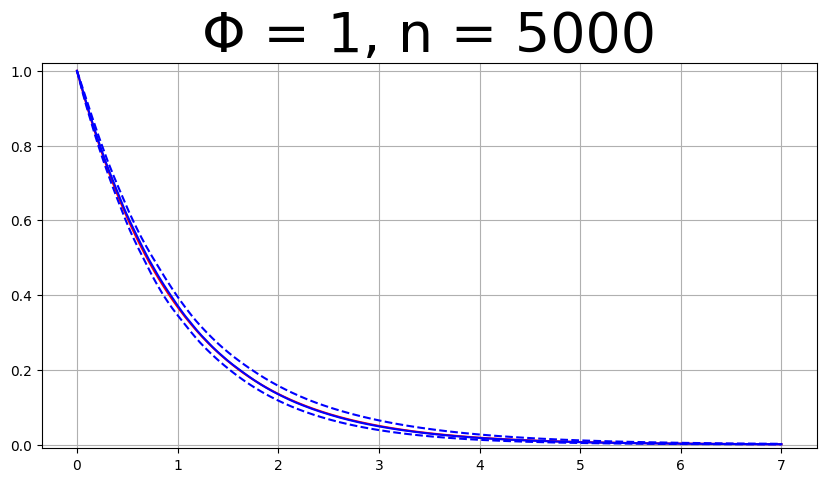

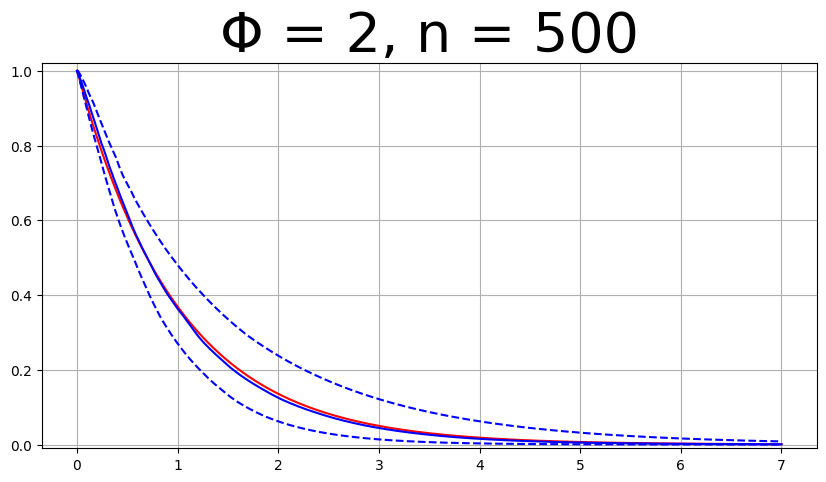

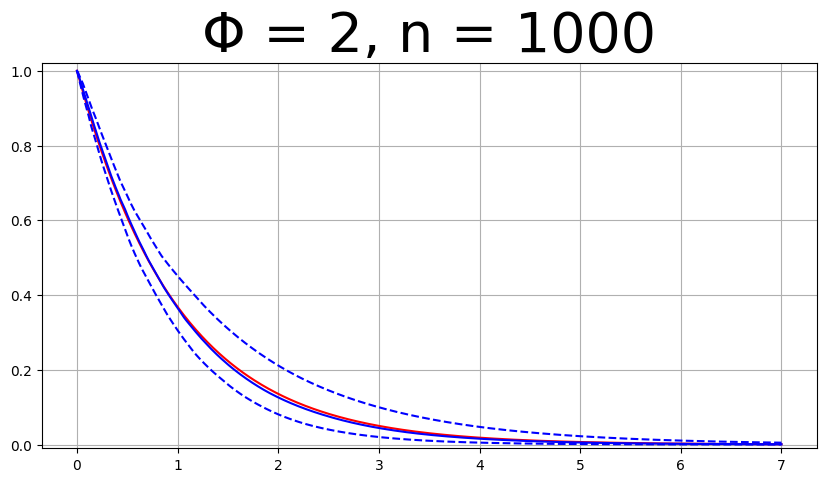

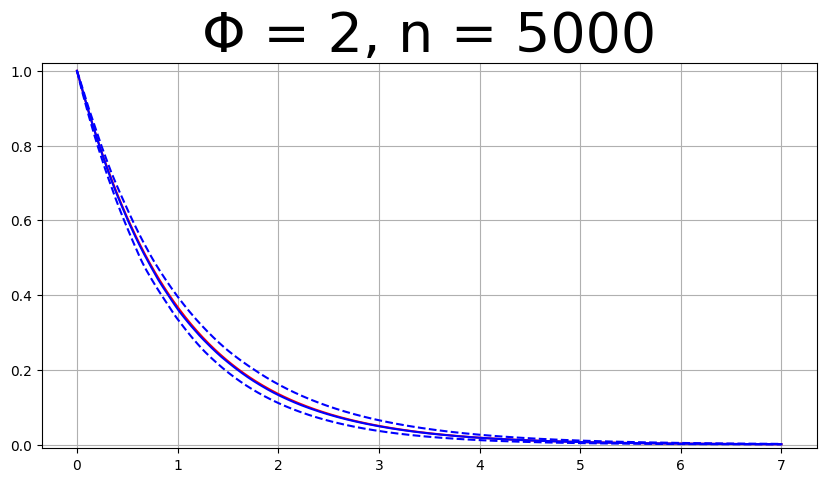

In [ ]:
# NB new loss
for i in [0.1, 1, 2]:
  for j in [500, 1000, 5000]:
    path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial/phi" + str(i) + "/n" + str(j) + "/"
    alpha_hat = pd.read_csv(path + "params_n" + str(j) + ".csv")
    plotS1curves(alpha_hat, i, j)

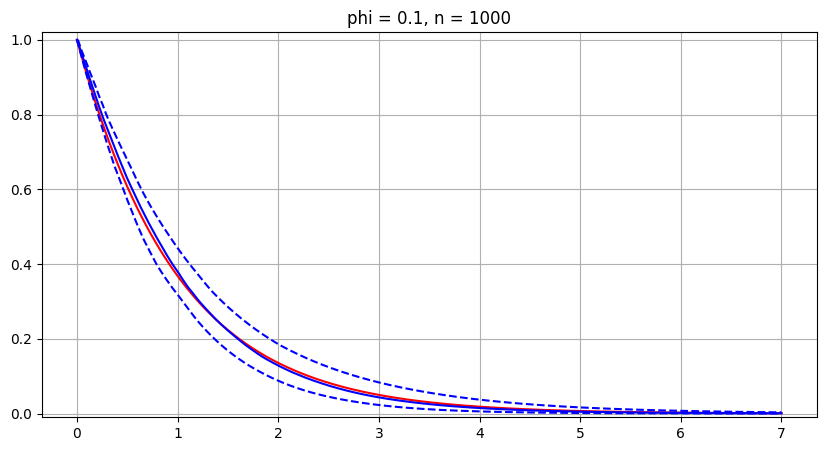

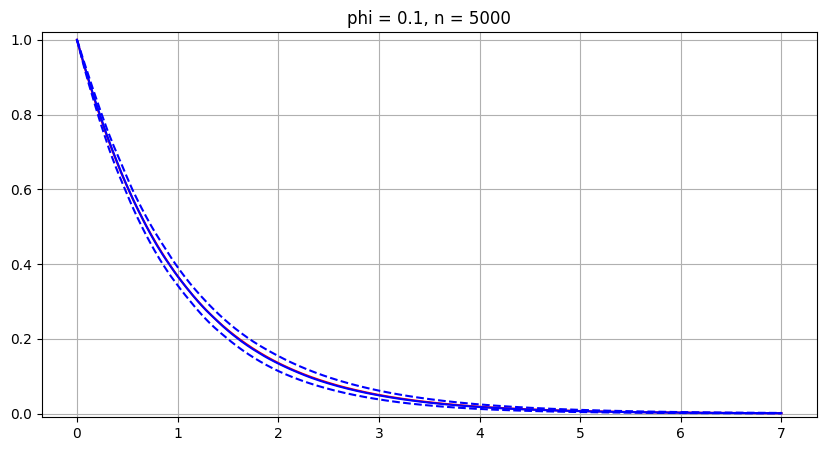

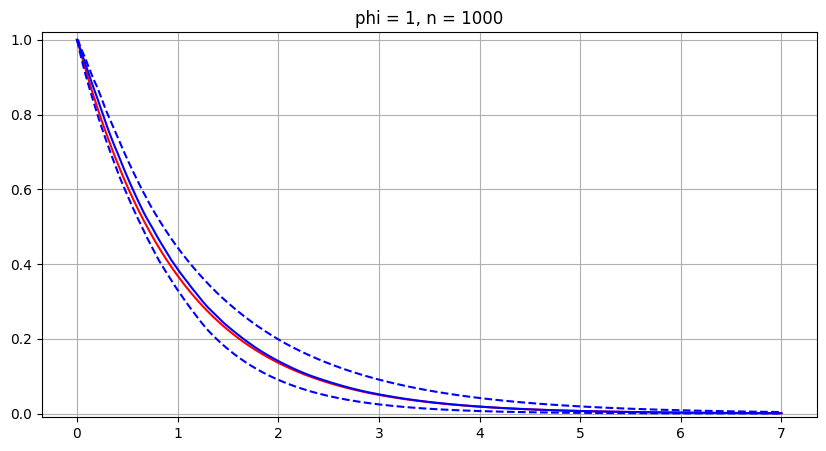

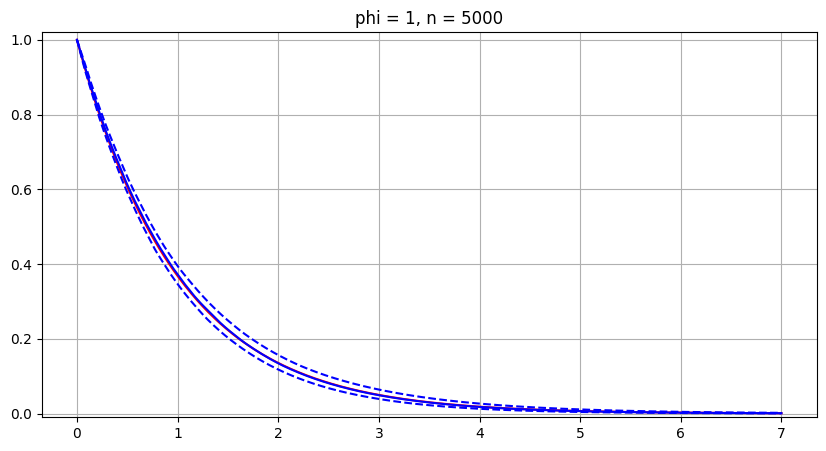

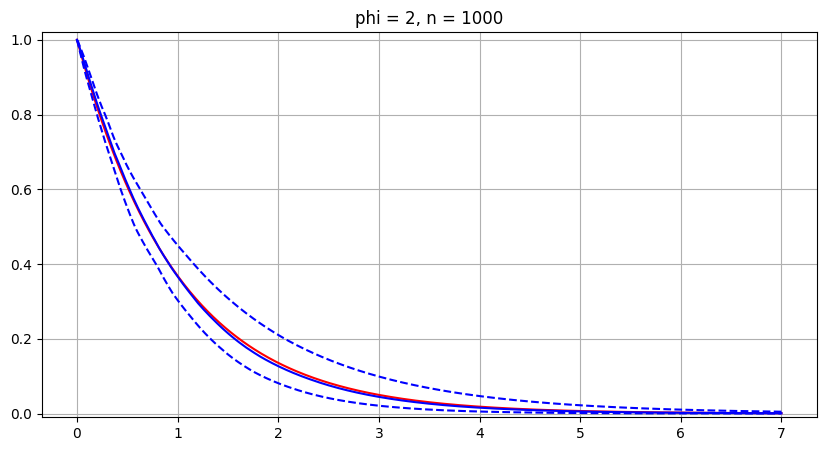

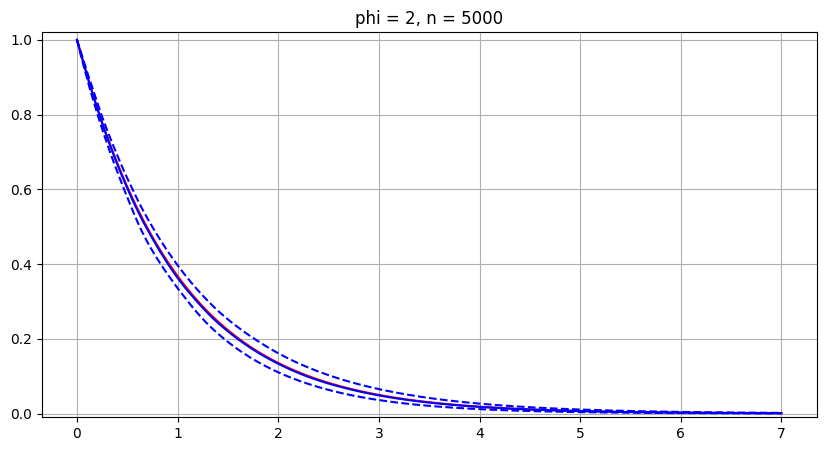

In [ ]:
# NB
for i in [0.1, 1, 2]:
  for j in [500, 1000, 5000]:
    path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial/phi" + str(i) + "/n" + str(j) + "/"
    alpha_hat = pd.read_csv(path + "params_n" + str(j) + ".csv")
    plotS1curves(alpha_hat, i, j)

## Mean difference

In [ ]:
# Poisson model
sim = pd.DataFrame(columns = ["phi", "n", "Sp", "eta", "S1", "M", "p0"])
for i in [0.1, 1, 2]:
  for j in [500, 1000, 5000]:
    path_sim = "/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/phi" + str(i) + "/n" + str(j) + "/"
    path_data = "/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial/phi" + str(i) + "/n" + str(j) + "/"
    temp = simResults(path_sim, path_data, n = j*0.25, phi = i)
    temp.insert(0, "phi", i, True)
    sim = pd.concat([sim, temp], ignore_index=True)
sim

,phi,n,Sp,eta,S1,M,p0
0,0.1,125.0,0.029124,0.826139,0.000988,0.711111,0.039508
1,0.1,250.0,0.022288,0.616062,0.000480,0.647315,0.031316
2,0.1,1250.0,0.016053,0.437020,0.000356,0.587356,0.022225
3,1.0,125.0,0.018581,0.625853,0.003541,0.959991,0.031741
4,1.0,250.0,0.016349,0.586346,0.004146,0.977712,0.028994
5,1.0,1250.0,0.008335,0.295462,0.004666,0.874762,0.016766
6,2.0,125.0,0.020738,1.234360,0.014814,1.736038,0.041123
7,2.0,250.0,0.019442,1.175383,0.015617,1.881228,0.039116
8,2.0,1250.0,0.018116,1.109764,0.016917,1.839809,0.037153


In [ ]:
# NB new loss
sim = pd.DataFrame(columns = ["phi", "n", "Sp", "eta", "S1", "M", "p0"])
for i in [0.1, 1, 2]:
  for j in [500, 1000, 5000]:
    path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial/phi" + str(i) + "/n" + str(j) + "/"
    temp = simResults(path, path, n = j*0.25, phi = i)
    temp.insert(0, "phi", i, True)
    sim = pd.concat([sim, temp], ignore_index=True)
sim

,phi,n,Sp,eta,S1,M,p0
0,0.1,125.0,0.032145,0.930052,0.001381,0.788707,0.041554
1,0.1,250.0,0.025263,0.707812,0.000635,0.702467,0.033504
2,0.1,1250.0,0.017001,0.451592,0.000083,0.603041,0.022220
3,1.0,125.0,0.019935,0.610912,0.001490,1.076470,0.026581
4,1.0,250.0,0.016274,0.496323,0.000740,1.045644,0.020851
5,1.0,1250.0,0.004367,0.102307,0.000086,0.837149,0.005509
6,2.0,125.0,0.015165,0.668547,0.001373,1.734697,0.019151
7,2.0,250.0,0.008824,0.362249,0.000585,1.750102,0.010266
8,2.0,1250.0,0.002831,0.106550,0.000092,1.550582,0.003175


In [ ]:
# NB model 1
sim = pd.DataFrame(columns = ["phi", "n", "Sp", "eta", "S1", "M"])
for i in [0.1, 1, 2]:
  for j in [1000, 5000]:
    path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial/phi" + str(i) + "/n" + str(j) + "/"
    temp = simResults(path, path, n = j*0.25, phi = i)
    temp.insert(0, "phi", i, True)
    sim = pd.concat([sim, temp], ignore_index=True)
sim

,phi,n,Sp,eta,S1,M
0,0.1,250.0,0.025156,0.701132,0.000640,0.704447
1,0.1,1250.0,0.017148,0.453578,0.000081,0.606347
2,1.0,250.0,0.015864,0.483864,0.000705,1.049201
3,1.0,1250.0,0.004473,0.104798,0.000080,0.838093
4,2.0,250.0,0.008469,0.346607,0.000582,1.739596
5,2.0,1250.0,0.002721,0.102598,0.000094,1.548054


## AUC

In [ ]:
# Poisson model
auc = pd.DataFrame(columns = ["phi", "n", "Train AUC", "Test AUC"])
for i in [0.1, 1, 2]:
  for j in [500, 1000, 5000]:
    path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Poisson/phi" + str(i) + "/n" + str(j) + "/"
    train_auc = []
    test_auc = []
    for sample in range(1,101):
      train_res = pd.read_csv(path + str(sample) + "_TrainRes" + '.csv')
      test_res = pd.read_csv(path + str(sample) + "_TestRes" + '.csv')
      train_auc.append(aucFI(train_res.eta.values, i))
      test_auc.append(aucFI(test_res.eta.values, i))

    temp = pd.DataFrame({'phi': i, 'n': j, 'Train AUC': train_auc, 'Test AUC': test_auc})
    auc = pd.concat([auc, temp])

auc.groupby(['phi', 'n']).agg('mean')

Train AUC  Test AUC
phi n                        
0.1 500    0.839108  0.823816
    1000   0.826987  0.819386
    5000   0.806683  0.804761
1.0 500    0.684517  0.662885
    1000   0.638764  0.629546
    5000   0.578341  0.576895
2.0 500    0.594320  0.580597
    1000   0.578684  0.570287
    5000   0.536130  0.535386

In [ ]:
# NB new loss
auc = pd.DataFrame(columns = ["phi", "n", "Train AUC", "Test AUC"])
for i in [0.1, 1, 2]:
  for j in [500, 1000, 5000]:
    path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial/phi" + str(i) + "/n" + str(j) + "/"
    train_auc = []
    test_auc = []
    for sample in range(1,101):
      train_res = pd.read_csv(path + str(sample) + "_TrainRes" + '.csv')
      test_res = pd.read_csv(path + str(sample) + "_TestRes" + '.csv')
      train_auc.append(aucFI(train_res.eta.values, i))
      test_auc.append(aucFI(test_res.eta.values, i))

    temp = pd.DataFrame({'phi': i, 'n': j, 'Train AUC': train_auc, 'Test AUC': test_auc})
    auc = pd.concat([auc, temp])

auc.groupby(['phi', 'n']).agg('mean')

Train AUC  Test AUC
phi n                        
0.1 500    0.848120  0.833626
    1000   0.847051  0.838269
    5000   0.829856  0.827632
1.0 500    0.740800  0.714441
    1000   0.702033  0.689066
    5000   0.628346  0.625909
2.0 500    0.671367  0.650770
    1000   0.633805  0.623909
    5000   0.579396  0.578014

In [ ]:
# NB model 1
auc = pd.DataFrame(columns = ["phi", "n", "Train AUC", "Test AUC"])
for i in [0.1, 1, 2]:
  for j in [1000, 5000]:
    path = "/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial/phi" + str(i) + "/n" + str(j) + "/"
    train_auc = []
    test_auc = []
    for sample in range(1,101):
      train_res = pd.read_csv(path + str(sample) + "_TrainRes" + '.csv')
      test_res = pd.read_csv(path + str(sample) + "_TestRes" + '.csv')
      train_auc.append(aucFI(train_res.eta.values, i))
      test_auc.append(aucFI(test_res.eta.values, i))

    temp = pd.DataFrame({'phi': i, 'n': j, 'Train AUC': train_auc, 'Test AUC': test_auc})
    auc = pd.concat([auc, temp])

auc.groupby(['phi', 'n']).agg('mean')

Train AUC  Test AUC
phi n                        
0.1 1000   0.845419  0.838072
    5000   0.830735  0.828575
1.0 1000   0.698057  0.686295
    5000   0.628899  0.626533
2.0 1000   0.630470  0.621484
    5000   0.578342  0.576856